In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer



In [98]:
#Display option to see more columns. Usefull to see all the columns of Dummy variables for Machine Learning
pd.set_option('display.max_columns', 120)

#make the charts look better for displays with retina resolution 
%config InlineBackend.figure_format = 'retina'

In [99]:
pd.set_option('display.max_rows', None)

### Read in data and basic data processing

#### todo mongodb and full year

In [100]:
GoT_df = pd.read_csv('C:\\data files\\All Clean.csv')

In [101]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status
0,9,harpersbazaarsg,harpersbazaarsg,tweet,fri apr 01 07:00:22 +0000 2016,715795927672496129,this is just insane for a tv series: https://t...,"['got', 'gameofthrones']",False
1,10,shagil_,firstpost,mentions,fri apr 01 07:02:47 +0000 2016,715796535875932160,rt @firstpost: 'heavy bubbles is secret of my ...,['gameofthrones'],True
2,15,gameofthrones1v,gameofthrones1v,tweet,fri apr 01 07:16:24 +0000 2016,715799962588692483,#gameofthrones game of thrones: season 3 (#dvd...,"['gameofthrones', 'dvd']",False
3,18,jennieloveslife,jennieloveslife,tweet,fri apr 01 07:26:20 +0000 2016,715802462389714944,why is everybody lying about jon snow?\n\nhttp...,['gameofthrones'],False
4,19,davidgmcneill,syidmassiah,mentions,fri apr 01 07:26:27 +0000 2016,715802491762384900,rt @syidmassiah: awesome #gameofthrones https:...,['gameofthrones'],True


In [102]:
GoT_df.isnull().sum()

Unnamed: 0        0
poster            0
recipient         4
relationship      0
tweet date        0
tweet id          0
tweet             0
hashtags          0
retweet status    0
dtype: int64

In [103]:
#convert to date and get rid of time stamp on date
GoT_df['tweet date'] = pd.to_datetime(GoT_df['tweet date'])
GoT_df['date'] = GoT_df['tweet date'].dt.date


In [104]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status,date
0,9,harpersbazaarsg,harpersbazaarsg,tweet,2016-04-01 07:00:22+00:00,715795927672496129,this is just insane for a tv series: https://t...,"['got', 'gameofthrones']",False,2016-04-01
1,10,shagil_,firstpost,mentions,2016-04-01 07:02:47+00:00,715796535875932160,rt @firstpost: 'heavy bubbles is secret of my ...,['gameofthrones'],True,2016-04-01
2,15,gameofthrones1v,gameofthrones1v,tweet,2016-04-01 07:16:24+00:00,715799962588692483,#gameofthrones game of thrones: season 3 (#dvd...,"['gameofthrones', 'dvd']",False,2016-04-01
3,18,jennieloveslife,jennieloveslife,tweet,2016-04-01 07:26:20+00:00,715802462389714944,why is everybody lying about jon snow?\n\nhttp...,['gameofthrones'],False,2016-04-01
4,19,davidgmcneill,syidmassiah,mentions,2016-04-01 07:26:27+00:00,715802491762384900,rt @syidmassiah: awesome #gameofthrones https:...,['gameofthrones'],True,2016-04-01


In [105]:
#find any missing dates
#GoT_df = GoT_df.set_index('date')
#print(pd.date_range(start='2016-04-01', end='2016-06-30').difference(GoT_df.index))
#reindex
#GoT_df = GoT_df.sort_index().reset_index(drop=True)

In [106]:
# Drop columns. Only interested in tweet text and date
GoT_df.drop(['Unnamed: 0','poster','recipient','relationship','tweet date','tweet id','hashtags','retweet status'], axis=1,inplace=True)

In [107]:
GoT_df.head()

,tweet,date
0,this is just insane for a tv series: https://t...,2016-04-01
1,rt @firstpost: 'heavy bubbles is secret of my ...,2016-04-01
2,#gameofthrones game of thrones: season 3 (#dvd...,2016-04-01
3,why is everybody lying about jon snow?\n\nhttp...,2016-04-01
4,rt @syidmassiah: awesome #gameofthrones https:...,2016-04-01


### Basic Sentiment Analysis

In [108]:
analyzer = SentimentIntensityAnalyzer()

GoT_df['polarity'] = GoT_df['tweet'].apply(lambda x: analyzer.polarity_scores(x))
GoT_df.head()

,tweet,date,polarity
0,this is just insane for a tv series: https://t...,2016-04-01,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp..."
1,rt @firstpost: 'heavy bubbles is secret of my ...,2016-04-01,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'comp..."
2,#gameofthrones game of thrones: season 3 (#dvd...,2016-04-01,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp..."
3,why is everybody lying about jon snow?\n\nhttp...,2016-04-01,"{'neg': 0.298, 'neu': 0.702, 'pos': 0.0, 'comp..."
4,rt @syidmassiah: awesome #gameofthrones https:...,2016-04-01,"{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'comp..."


In [109]:
# Change df structure to have pos, neg and neu columns
GoT_df = pd.concat(
    [GoT_df.drop(['polarity'], axis=1), 
     GoT_df['polarity'].apply(pd.Series)], axis=1)
GoT_df.head()

,tweet,date,neg,neu,pos,compound
0,this is just insane for a tv series: https://t...,2016-04-01,0.231,0.769,0.000,-0.4019
1,rt @firstpost: 'heavy bubbles is secret of my ...,2016-04-01,0.000,0.879,0.121,0.2960
2,#gameofthrones game of thrones: season 3 (#dvd...,2016-04-01,0.138,0.862,0.000,-0.3400
3,why is everybody lying about jon snow?\n\nhttp...,2016-04-01,0.298,0.702,0.000,-0.5267
4,rt @syidmassiah: awesome #gameofthrones https:...,2016-04-01,0.000,0.494,0.506,0.6249


In [110]:
# Change df structure to have sentiment column
GoT_df['sentiment'] = GoT_df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
GoT_df.head()

,tweet,date,neg,neu,pos,compound,sentiment
0,this is just insane for a tv series: https://t...,2016-04-01,0.231,0.769,0.000,-0.4019,negative
1,rt @firstpost: 'heavy bubbles is secret of my ...,2016-04-01,0.000,0.879,0.121,0.2960,positive
2,#gameofthrones game of thrones: season 3 (#dvd...,2016-04-01,0.138,0.862,0.000,-0.3400,negative
3,why is everybody lying about jon snow?\n\nhttp...,2016-04-01,0.298,0.702,0.000,-0.5267,negative
4,rt @syidmassiah: awesome #gameofthrones https:...,2016-04-01,0.000,0.494,0.506,0.6249,positive


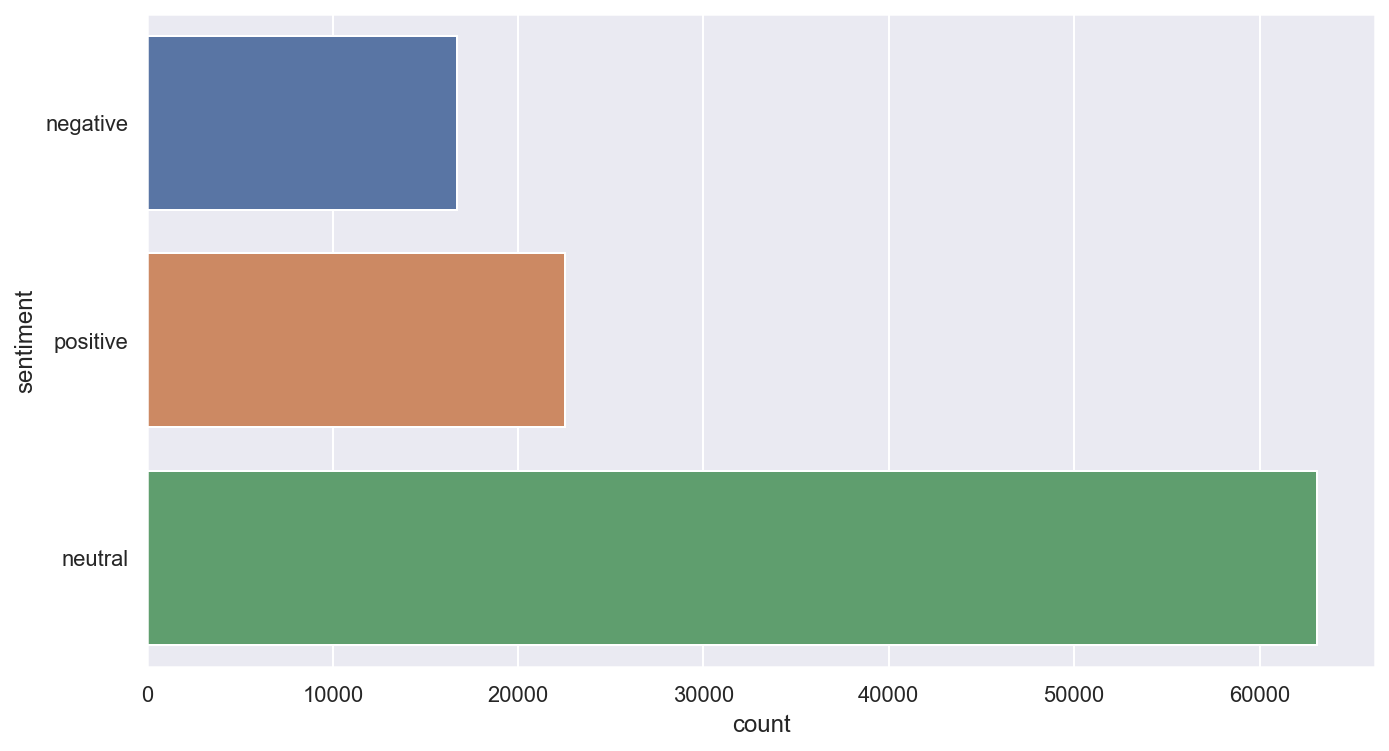

In [111]:
# Number of tweets per sentiment
sns.countplot(y='sentiment', 
             data=GoT_df, 
             );

In [112]:
#Fing how mant of each
print(GoT_df['sentiment'].value_counts()['positive'])
print(GoT_df['sentiment'].value_counts()['negative'])
print(GoT_df['sentiment'].value_counts()['neutral'])

22548
16717
63077


In [113]:
# Drop columns. Only interested in sentiment and date
GoT_df.drop(['tweet','neg','neu','pos','compound'], axis=1,inplace=True)
GoT_df.head()

,date,sentiment
0,2016-04-01,negative
1,2016-04-01,positive
2,2016-04-01,negative
3,2016-04-01,negative
4,2016-04-01,positive


In [114]:
# Get 2 dataframes for pos, neg 
# Will not be interested in neu
GoT_positive = GoT_df.loc[GoT_df['sentiment'] == 'positive']
GoT_negative = GoT_df.loc[GoT_df['sentiment'] == 'negative']

In [115]:
GoT_positive.head(91)

,date,sentiment
1,2016-04-01,positive
4,2016-04-01,positive
5,2016-04-01,positive
6,2016-04-01,positive
9,2016-04-01,positive
11,2016-04-01,positive
12,2016-04-01,positive
19,2016-04-01,positive
22,2016-04-01,positive
24,2016-04-01,positive


In [116]:
pos = GoT_positive.groupby('date', as_index=False).count()
neg = GoT_negative.groupby('date', as_index=False).count()

In [117]:
pos.shape

(88, 2)

In [118]:
pos.head(90)

,date,sentiment
0,2016-04-01,35
1,2016-04-02,16
2,2016-04-03,13
3,2016-04-04,27
4,2016-04-05,14
5,2016-04-06,12
6,2016-04-07,31
7,2016-04-08,35
8,2016-04-09,24
9,2016-04-10,42


#### Missing Data

In [119]:
pos.loc[62.5] = ['2016-06-03', 64]
pos.loc[62.6] = ['2016-06-04', 77]
pos.loc[62.7] = ['2016-06-05', 125]
pos.loc[62.8] = ['2016-06-06', 732]
pos = pos.sort_index().reset_index(drop=True)

In [120]:
pos.at[77, 'sentiment'] = 54

In [121]:
pos.shape

(92, 2)

In [122]:
pos.head(92)

,date,sentiment
0,2016-04-01,35
1,2016-04-02,16
2,2016-04-03,13
3,2016-04-04,27
4,2016-04-05,14
5,2016-04-06,12
6,2016-04-07,31
7,2016-04-08,35
8,2016-04-09,24
9,2016-04-10,42


In [123]:
#find any missing dates
#pos = pos.set_index('date')
#print(pd.date_range(start='2016-04-01', end='2016-06-30').difference(pos.index))
#reindex
#GoT_df = GoT_df.sort_index().reset_index(drop=True)

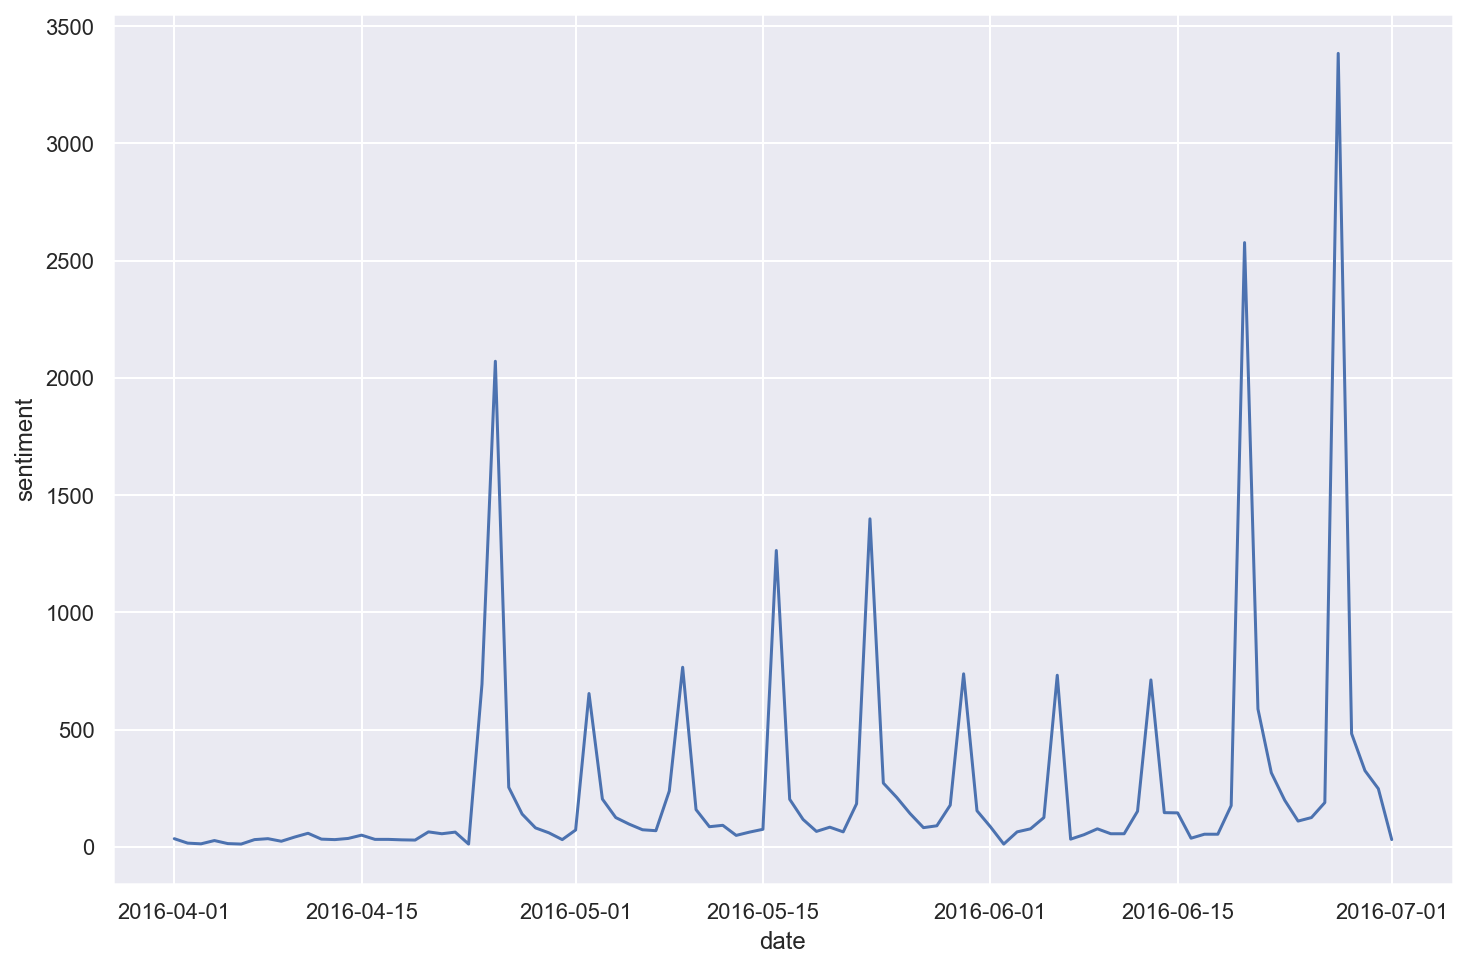

In [124]:
#Graph of positive sentiment over time

sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale=1)
myfig = sns.lineplot(x = 'date', y = 'sentiment', data = pos)
plt.show()